In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

100% 2.69G/2.70G [00:31<00:00, 146MB/s]
100% 2.70G/2.70G [00:31<00:00, 91.6MB/s]


In [3]:
import zipfile

zip_ref = zipfile.ZipFile('/content/new-plant-diseases-dataset.zip')
zip_ref.extractall()
zip_ref.close()

In [4]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import random
random.seed(9)


# Define transforms to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize image data
])

# Paths to the directories containing training and validation data
train_data_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
val_data_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_data_dir = '/content/test'



# Load the training dataset using ImageFolder
train_full_dataset = ImageFolder(root=train_data_dir, transform=transform)
print(f"Full training size: {len(train_full_dataset.imgs)}")

# Load the validation dataset using ImageFolder
val_full_dataset = ImageFolder(root=val_data_dir, transform=transform)

# Load the validation dataset using ImageFolder
test_dataset = ImageFolder(root=test_data_dir, transform=transform)


def get_random_indices(full_dataset):
    selected_indices = []

    # Iterate over the classes in the dataset
    for class_idx in range(len(full_dataset.classes)):
        # Get the indices of images belonging to the current class
        class_indices = [idx for idx, (_, label_idx) in enumerate(full_dataset.imgs) if label_idx == class_idx]
        # Select a percentage of images from the current class
        num_selected = int(len(class_indices) * 0.1)
        selected_indices.extend(random.sample(class_indices, num_selected))

    return selected_indices

selected_train_indices = get_random_indices(train_full_dataset)
selected_val_indices = get_random_indices(val_full_dataset)

train_subset_dataset = Subset(train_full_dataset, selected_train_indices)
val_subset_dataset = Subset(val_full_dataset, selected_val_indices)
print(f"Trimmed training size: {len(train_subset_dataset)}")


# Create DataLoaders
batch_size = 96
train_dataloader = DataLoader(train_subset_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(train_subset_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Full training size: 70295
Trimmed training size: 7013


In [5]:
import os
import cv2
import json

train_test_labels = {'AppleCedarRust': 'Apple___Cedar_apple_rust',
                    'AppleScab': 'Apple___Apple_scab',
                    'CornCommonRust': 'Corn_(maize)___Common_rust_',
                    'PotatoEarlyBlight': 'Potato___Early_blight',
                    'PotatoHealthy': 'Potato___healthy',
                    'TomatoEarlyBlight': 'Tomato___Early_blight',
                    'TomatoHealthy': 'Tomato___healthy',
                    'TomatoYellowCurlVirus': 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
                    }

test_data_dir = '/content/test/test'

# test_images = []
test_labels = []
for td in sorted(os.listdir(test_data_dir)):
    # test_images.append(os.path.join(test_data_dir, td))
    test_labels.append(train_test_labels[td[:-5]])


# test_images = [cv2.resize(cv2.imread(x), (224, 224)) for x in test_images]
# test_images = torch.stack([torch.tensor(x, dtype=torch.float32) for x in test_images])
# test_images = torch.transpose(test_images, -1, -3)
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# test_images = normalize(test_images)

class_dict = {j: i for i, j in enumerate(train_full_dataset.classes)}
test_labels = [class_dict[x] for x in test_labels]
test_labels = torch.tensor(test_labels, dtype=torch.int64)


with open('class_mapper.json', 'w') as json_file:
    json.dump(class_dict, json_file)

In [6]:
import torch.nn as nn
import torchvision.models as models

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze the parameters of the pre-trained layers
for param in vgg16.parameters():
    param.requires_grad = False

# Modify the last fully connected layer for the number of classes in your dataset
num_classes = len(train_full_dataset.classes)
vgg16.classifier[-1] = nn.Linear(in_features=vgg16.classifier[-1].in_features, out_features=num_classes)
vgg16 = vgg16.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(vgg16.parameters(), lr=1e-3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 124MB/s] 


In [7]:
# # Train the model
# num_epochs = 10
# for epoch in range(num_epochs):
#     vgg16.train()  # Set the model to train mode
#     running_loss = 0.0
#     for inputs, labels in train_dataloader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = vgg16(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_dataloader)}")

# # Validate the model
# vgg16.eval()  # Set the model to evaluation mode
# correct = 0
# total = 0
# with torch.no_grad():
#     for inputs, labels in val_dataloader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = vgg16(inputs)
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f"Validation Accuracy: {100 * correct / total}%")

In [9]:
# Train the model
import torch.nn.functional as F


num_epochs = 10
train_outs = []
val_outs = []

for epoch in range(num_epochs):
    vgg16.train()
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        predicted = torch.argmax(F.softmax(outputs, dim=1), dim=1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_running_loss/len(train_dataloader):.04f}, Training Accuracy: {100 * train_correct / train_total:.02f}%", end="\t")
    train_outs.append((train_running_loss/len(train_dataloader), train_correct / train_total))

    # Validate the model
    vgg16.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            predicted = torch.argmax(F.softmax(outputs, dim=1), dim=1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    print(f"Validation Loss: {val_running_loss/len(val_dataloader):.04f}, Validation Accuracy: {100 * val_correct / val_total:.02f}%")
    val_outs.append((val_running_loss/len(val_dataloader), val_correct / val_total))

Epoch 1/10, Training Loss: 1.5488, Training Accuracy: 59.49%	Validation Loss: 0.7488, Validation Accuracy: 82.79%
Epoch 2/10, Training Loss: 0.7347, Training Accuracy: 78.85%	Validation Loss: 0.5173, Validation Accuracy: 88.07%
Epoch 3/10, Training Loss: 0.6045, Training Accuracy: 82.60%	Validation Loss: 0.4061, Validation Accuracy: 90.80%
Epoch 4/10, Training Loss: 0.5218, Training Accuracy: 84.04%	Validation Loss: 0.3487, Validation Accuracy: 92.03%
Epoch 5/10, Training Loss: 0.4849, Training Accuracy: 85.37%	Validation Loss: 0.3036, Validation Accuracy: 93.10%
Epoch 6/10, Training Loss: 0.4417, Training Accuracy: 86.10%	Validation Loss: 0.2722, Validation Accuracy: 93.77%
Epoch 7/10, Training Loss: 0.4161, Training Accuracy: 87.01%	Validation Loss: 0.2466, Validation Accuracy: 94.52%
Epoch 8/10, Training Loss: 0.3929, Training Accuracy: 87.37%	Validation Loss: 0.2232, Validation Accuracy: 94.98%
Epoch 9/10, Training Loss: 0.3771, Training Accuracy: 88.08%	Validation Loss: 0.2039, Va

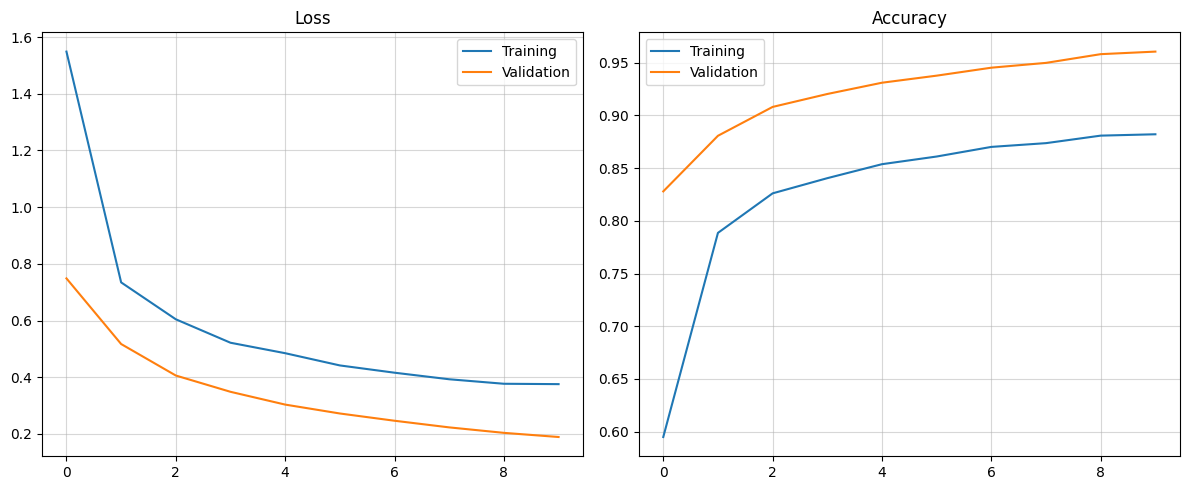

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot([x[0] for x in train_outs], label='Training')
plt.plot([x[0] for x in val_outs], label='Validation')
plt.title('Loss')
plt.legend()
plt.grid(alpha=0.5)

plt.subplot(1, 2, 2)
plt.plot([x[1] for x in train_outs], label='Training')
plt.plot([x[1] for x in val_outs], label='Validation')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.5)

plt.tight_layout()
plt.show()

In [11]:
# test_images, test_labels = test_images.to(device), test_labels.to(device)
test_labels = test_labels.to(device)

vgg16.eval()
with torch.no_grad():
    for input, labels in test_dataloader:
        outputs = vgg16(input.to(device))
        loss = criterion(outputs, test_labels)
        predicted = torch.argmax(F.softmax(outputs, dim=1), dim=1)
        accuracy = (predicted == test_labels).sum().item()
        print(f"Test Loss: {loss:.04f}, Test Accuracy: {100 * accuracy/test_labels.size(0):.02f}%")

Test Loss: 0.5976, Test Accuracy: 78.79%


In [12]:
torch.save(vgg16.state_dict(), 'VGG16_transfer_learning_model.pth')

In [ ]:
from google.colab import files

files.download('/content/VGG16_transfer_learning_model.pth')